In [33]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from typing import Optional, Tuple

from rxitect.data.datasets import SingleTargetQSARDataset  # TODO: Rename to QSARDataset
from rxitect.data.structs import RegressionQSARModel
from rxitect.data.process import construct_qsar_dataset

In [2]:
target = 'CHEMBL251'

In [3]:
ds = SingleTargetQSARDataset.load_from_file(train_file=f"../data/processed/ligand_{target}_train_seed=42.csv",
                                            test_file=f"../data/processed/ligand_{target}_test_seed=42.csv",
                                            target=target)

In [4]:
reg = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=0.3, n_jobs=-1)

In [18]:
xgb = XGBRegressor(n_estimators=500, tree_method="gpu_hist", gpu_id=0, max_depth=20, learning_rate=0.3)

In [32]:
svr = SVR(C=2**-5)

In [34]:
scaler = MinMaxScaler()

In [35]:
def regression_cv5_with_independent_test(estimator, qsar_dataset: SingleTargetQSARDataset, scaler = None, out_dir: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    """
    X_train, y_train, X_test, y_test = qsar_dataset.get_train_test_data()
    
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
    folds = KFold(5).split(X_train)
    cvs = np.zeros(y_train.shape)
    inds = np.zeros(y_test.shape)
    for idx_train, idx_test in folds:
        estimator.fit(X_train[idx_train], y_train[idx_train], sample_weight=[1 if v >= 4 else 0.1 for v in y_train[idx_train]])
        cvs[idx_train] = estimator.predict(X_train[idx_train])
        inds += estimator.predict(X_test)
        
    if out_dir:
        df_train, df_test = qsar_dataset.df_train, qsar_dataset.df_test
        df_train['pred'], df_test['pred'] = cvs, inds/5
        df_train_c = df_train[df_train['pchembl_value'] != 3.99].reset_index(drop=True)
        df_test_c = df_test[df_test['pchembl_value'] != 3.99].reset_index(drop=True)
        
        est_desc = estimator.__class__.__name__
        target = qsar_dataset.target
        df_train_c.to_csv(os.path.join(out_dir, f"{est_desc}_{target}.cv5.csv"), index=False)
        df_test_c.to_csv(os.path.join(out_dir, f"{est_desc}_{target}.ind.csv"), index=False)
        
    return cvs, inds/5

In [37]:
cvs, inds = regression_cv5_with_independent_test(svr, ds, scaler, "../data/final/")

In [38]:
df_train, df_test = ds.df_train, ds.df_test
df_train['pred'], df_test['pred'] = cvs, inds

In [39]:
df_train_c = df_train[df_train['pchembl_value'] != 3.99].reset_index(drop=True)
df_test_c = df_test[df_test['pchembl_value'] != 3.99].reset_index(drop=True)

<AxesSubplot:xlabel='pchembl_value', ylabel='pred'>

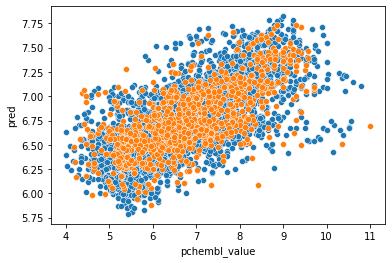

In [40]:
sns.scatterplot(x=df_train_c['pchembl_value'] , y=df_train_c['pred'])
sns.scatterplot(x=df_test_c['pchembl_value'], y=df_test_c['pred'])

In [41]:
rmse = mean_squared_error(y_pred=df_test_c['pred'], y_true=df_test_c['pchembl_value'], squared=True)
r2 = r2_score(y_pred=df_test_c['pred'], y_true=df_test_c['pchembl_value'])
print(f"RMSE: {rmse}\nR2: {r2}")

RMSE: 1.0219413750280244
R2: 0.2832055054018088


In [30]:
reg.__class__.__name__

'RandomForestRegressor'